In [1]:
from collections import Counter
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['SimHei']

### 1. 异常值校验

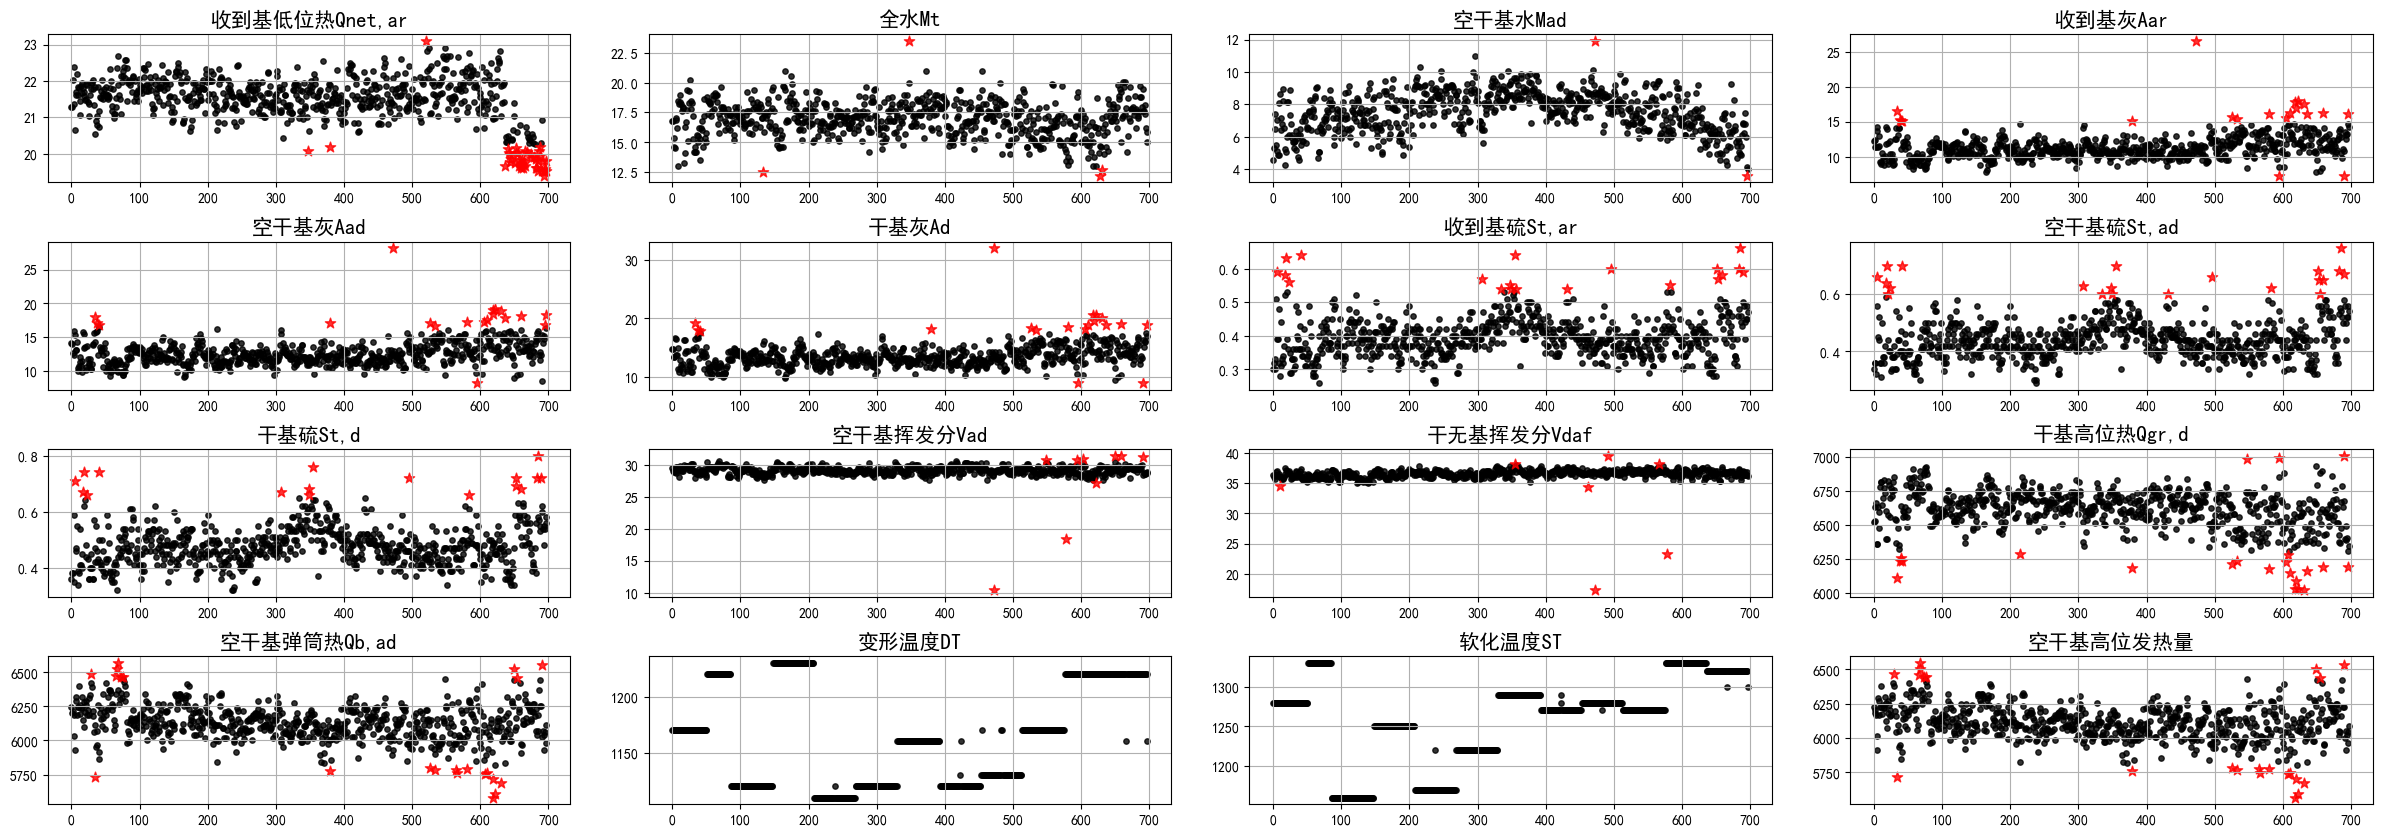

,分厂,入炉日期,存在问题
5,A,2020-01-06,"收到基硫St,ar过大, 空干基硫St,ad过大, 干基硫St,d过大,"
8,A,2020-01-09,"全水Mt过小,"
10,A,2020-01-11,"干无基挥发分Vdaf过小,"
17,A,2020-01-18,"收到基硫St,ar过大, 空干基硫St,ad过大, 干基硫St,d过大,"
19,A,2020-01-20,"收到基硫St,ar过大, 空干基硫St,ad过大, 干基硫St,d过大,"
...,...,...,...
693,B,2020-12-27,"收到基低位热Qnet,ar过小,"
694,B,2020-12-28,"收到基低位热Qnet,ar过小,"
695,B,2020-12-29,"收到基低位热Qnet,ar过小, 空干基灰Aad过大,"
696,B,2020-12-30,"收到基低位热Qnet,ar过小, 空干基水Mad过小, 收到基灰Aar过大, 空干基灰Aad..."


In [2]:
# 导入数据
file_name = r''+"./data/data.xlsx"
sheet_name = 'Sheet1'
table = pd.read_excel(file_name, sheet_name)
df = table.convert_dtypes(infer_objects=True)

# 图示校验结果
fig = plt.subplots(4, 4, figsize=(30,10))
fig = plt.subplots_adjust(wspace=0.15, hspace=0.4)
for i, col in enumerate(df.columns[2:]):
    data = df[col]
    q25 = data.quantile(q=0.25)  # 1/4位数
    q75 = data.quantile(q=0.75)  # 3/4位数
    iqr = q75 - q25  # 分位差
    l_lim = q25 - 1.5 * iqr  # 下限
    h_lim = q75 + 1.5 * iqr  # 上限
    abnormal = data[(data < l_lim) | (data > h_lim) | (data == 0)]  # 异常值
    normal = data[(data >= l_lim) & (data <= h_lim) & (data != 0)]  # 正常值
    plt.subplot(4,4,i+1)
    plt.title(col, size=15)
    plt.scatter(normal.index, normal, color='k', marker='.', s=60, alpha=0.8)
    plt.scatter(abnormal.index, abnormal, color='r', marker='*', s=60, alpha=0.8)
    plt.grid()
plt.show()

# 校验报告
df['存在问题'] = ''
names = df.iloc[:, 2:-1].columns
for name in names:
    data = df[name]
    lower = data.quantile(q=0.25)
    upper = data.quantile(q=0.75)
    iqr = upper - lower
    lower_idx = list(data<=(lower-1.5*iqr))
    upper_idx = list(data>=(upper+1.5*iqr))
    df.iloc[lower_idx, -1] += name+'过小, '
    df.iloc[upper_idx, -1] += name+'过大, '

df = df[df['存在问题']!='']
df[['分厂', '入炉日期', '存在问题']]

### 2. 规律校验
#### 2.1 规律挖掘

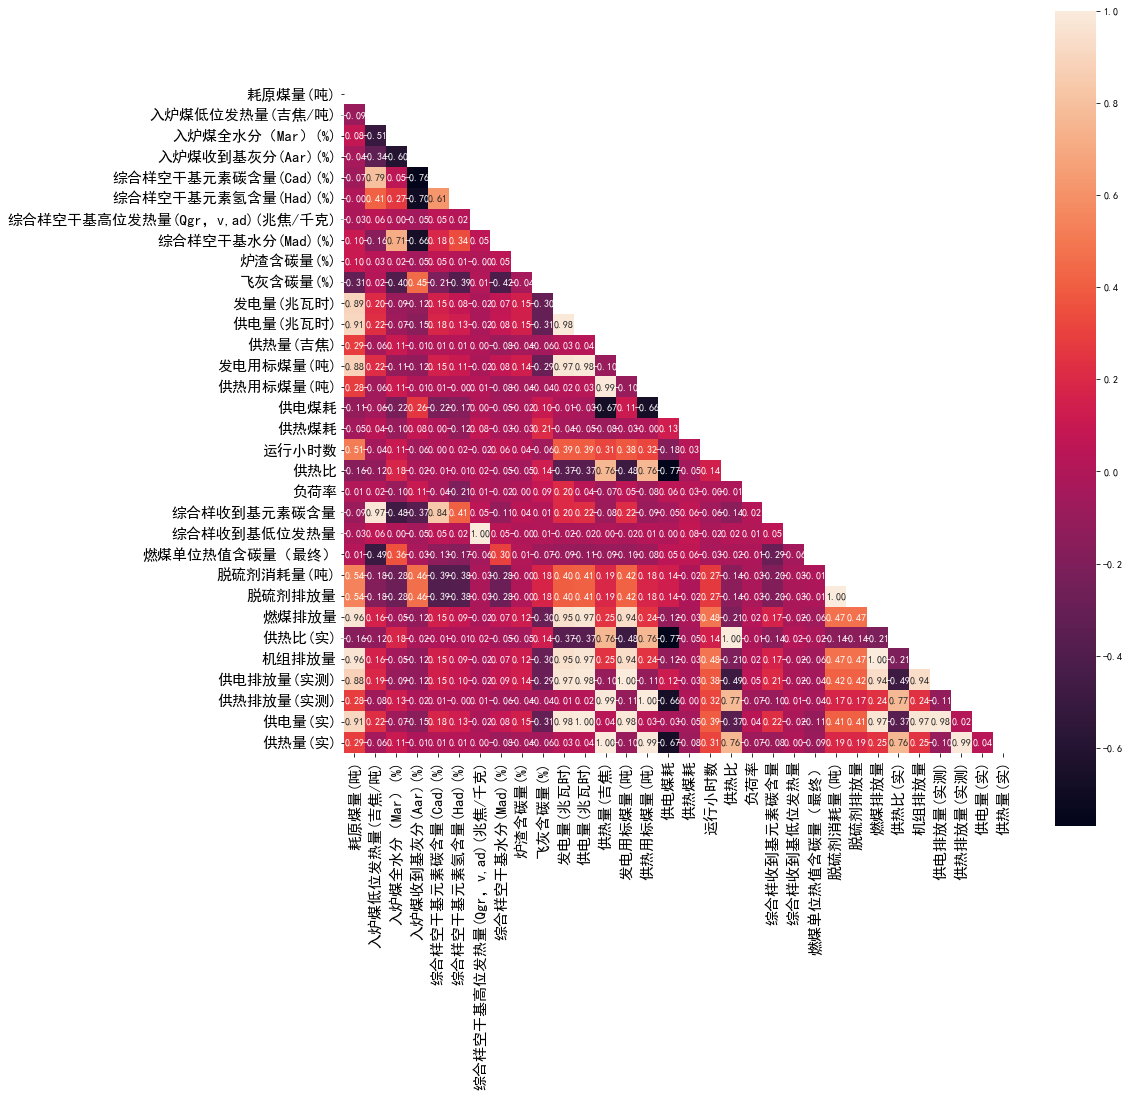

In [3]:

from utils.tool_for_04 import *

# 导入并预处理数据
file_name = "./data/火电4月月报数据.xls"
sheet_name = "结果集"
table = pd.read_excel(file_name, sheet_name)
table = table.convert_dtypes(infer_objects=True)
table = preprocess_table(table, max_nan_ratio, delete_cols)

# 规律挖掘
df = delete_col(table, delete_cols=["SHORT_NAME", "日期"])
df.index = list(range(0, df.shape[0]))
df = df[df!=0]
df = df.dropna(axis=0)
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, square=True, mask=mask, annot=True, fmt=".2f")
ax.tick_params(labelsize=15)
plt.show()

#### 2.2 规律校验

原始数据：1397 行 | 4 列


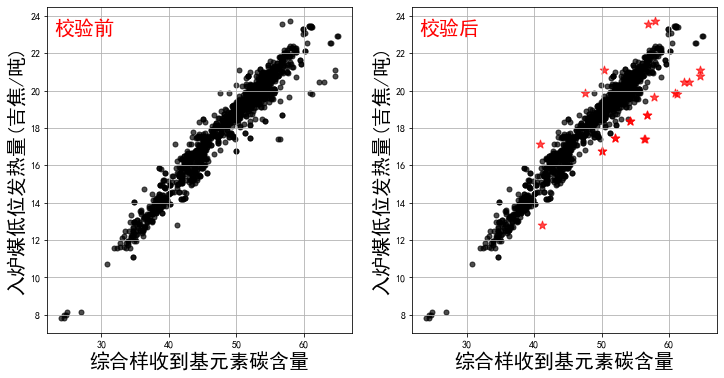

,SHORT_NAME,日期,问题
5,B,202201,不符合 综合样收到基元素碳含量 ~ 入炉煤低位发热量(吉焦/吨) 规律
9,A,202201,不符合 综合样收到基元素碳含量 ~ 入炉煤低位发热量(吉焦/吨) 规律
18,A,202202,不符合 综合样收到基元素碳含量 ~ 入炉煤低位发热量(吉焦/吨) 规律
22,B,202202,不符合 综合样收到基元素碳含量 ~ 入炉煤低位发热量(吉焦/吨) 规律
25,B,202201,不符合 综合样收到基元素碳含量 ~ 入炉煤低位发热量(吉焦/吨) 规律
88,A,202203,不符合 综合样收到基元素碳含量 ~ 入炉煤低位发热量(吉焦/吨) 规律
89,A,202204,不符合 综合样收到基元素碳含量 ~ 入炉煤低位发热量(吉焦/吨) 规律
322,B,202203,不符合 综合样收到基元素碳含量 ~ 入炉煤低位发热量(吉焦/吨) 规律
324,A,202201,不符合 综合样收到基元素碳含量 ~ 入炉煤低位发热量(吉焦/吨) 规律
326,B,202203,不符合 综合样收到基元素碳含量 ~ 入炉煤低位发热量(吉焦/吨) 规律


In [4]:

select_cols = ["SHORT_NAME", "日期", "综合样收到基元素碳含量", "入炉煤低位发热量(吉焦/吨)"]
data = table[select_cols]
data = data.replace(0, np.nan)
data = data.dropna(axis=0)
data.index = list(range(1, len(data)+1))
print(f"原始数据：{data.shape[0]} 行 | {data.shape[1]} 列")

# 提取x和y
x = data[select_cols[2]]
y = data[select_cols[3]]
xs = x.values.reshape(-1, 1)
ys = y.values

# 绘图1
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(x, y, marker='.', s=100, color='k', alpha=0.7)
ax1.set_xlabel(xlabel=select_cols[2], fontsize=20)
ax1.set_ylabel(ylabel=select_cols[3], fontsize=20)
ax1.text(23, 23, '校验前', size=20, color='red', weight='bold')
plt.grid()

# 拟合
model = LinearRegression()
model.fit(xs, ys)
ys_pred = pd.Series(model.predict(xs))  # 计算预测值
ys_pred.index = list(range(1, len(ys_pred)+1))

# 规律
resid = y - ys_pred       # 预测值与真实值的偏差
meanResid = resid.mean()  # 偏差的均值
stdResid = resid.std()    # 偏差的标准差
z_value = (resid - meanResid) / stdResid  # 计算偏差的z值

# 判别
threshold = 3
abnormal_idx = z_value[abs(z_value) >= threshold].index
normal_idx = z_value[abs(z_value) < threshold].index

# 绘图2
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(x[normal_idx], y[normal_idx], marker=".", s=100, color='k', alpha=0.7)
ax2.scatter(x[abnormal_idx], y[abnormal_idx], marker="*", s=80, color='r', alpha=0.7)
ax2.set_xlabel(xlabel=select_cols[2], fontsize=20)
ax2.set_ylabel(ylabel=select_cols[3], fontsize=20)
ax2.text(23, 23, '校验后', size=20, color='red', weight='bold')
plt.grid()
plt.show()

# 校验报告
result = data.iloc[abnormal_idx]
result = delete_col(result, select_cols[2:])
result["问题"] = "不符合 " + select_cols[2] + " ~ " + select_cols[3] + " 规律"
np.random.seed(1)
result['SHORT_NAME'] = np.random.choice(['A', 'B', 'C'], len(result))
result

### 2.3 模型校验

**输入：入炉煤全水分, 入炉煤收到基灰分, 综合样空干基元素碳含量, 综合样空干基元素氢含量**

**输出：入炉煤低位发热量**

**模型：支持向量机**

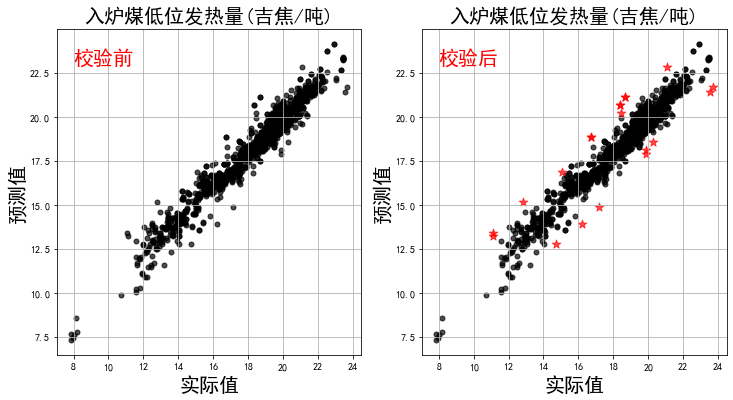

,SHORT_NAME,日期,问题
1,B,202203,偏离入炉煤发热量预测结果
2,A,202204,偏离入炉煤发热量预测结果
3,A,202202,偏离入炉煤发热量预测结果
4,B,202203,偏离入炉煤发热量预测结果
5,B,202203,偏离入炉煤发热量预测结果
6,A,202201,偏离入炉煤发热量预测结果
7,A,202203,偏离入炉煤发热量预测结果
8,B,202201,偏离入炉煤发热量预测结果
9,A,202201,偏离入炉煤发热量预测结果
10,B,202201,偏离入炉煤发热量预测结果


In [5]:

# 筛选数据
select_cols = [
    "SHORT_NAME", 
    "日期",
    '入炉煤低位发热量(吉焦/吨)',
    '入炉煤全水分（Mar）(%)', 
    '入炉煤收到基灰分(Aar)(%)', 
    '综合样空干基元素碳含量(Cad)(%)', 
    '综合样空干基元素氢含量(Had)(%)'
    ]
data = table[select_cols]
data = data.replace(0, np.nan)
data = data.dropna(axis=0)
data.index = list(range(1, len(data)+1))


# 提取x和y
x = data[select_cols[3:]]
y = data[select_cols[2]]
xs = x.values.reshape(-1, 4)
ys = y.values


# 拟合
model = LinearRegression()
model.fit(xs, ys)
ys_pred = pd.Series(model.predict(xs))  # 计算预测值
ys_pred.index = list(range(1, len(ys_pred)+1))

# 绘图1
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(y, ys_pred, marker=".", s=100, color='k', alpha=0.7)
ax1.set_xlabel(xlabel="实际值", fontsize=20)
ax1.set_ylabel(ylabel="预测值", fontsize=20)
ax1.text(8, 23, '校验前', size=20, color='red', weight='bold')
plt.title(select_cols[2], fontsize=20)
plt.grid()

# 规律
resid = ys - ys_pred      # 预测值与真实值的偏差
meanResid = resid.mean()  # 偏差的均值
stdResid = resid.std()    # 偏差的标准差
z_value = (resid - meanResid) / stdResid  # 计算偏差的z值

# 判别
threshold = 3
abnormal_idx = z_value[abs(z_value) >= threshold].index
normal_idx = z_value[abs(z_value) < threshold].index

# 绘图2
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(y[normal_idx], ys_pred[normal_idx], marker=".", s=100, color='k', alpha=0.7)
ax2.scatter(y[abnormal_idx], ys_pred[abnormal_idx], marker="*", s=80, color='r', alpha=0.7)
ax2.set_xlabel(xlabel="实际值", fontsize=20)
ax2.set_ylabel(ylabel="预测值", fontsize=20)
ax2.text(8, 23, '校验后', size=20, color='red', weight='bold')
plt.title(select_cols[2], fontsize=20)
plt.grid()
plt.show()

# 报表
result = data.iloc[abnormal_idx]
result = delete_col(result, select_cols[2:])
result["问题"] = "偏离入炉煤发热量预测结果"
result.index = list(range(1, len(result)+1))
np.random.seed(1)
result['SHORT_NAME'] = np.random.choice(['A', 'B', 'C'], len(result))
result